Using device: cuda
Number of classes: 9
Classes: [0 1 2 3 4 5 6 7 8]
Class distribution: [461 411 420 790 495 500 921 318 436]
Train size: 3326, Val size: 713, Test size: 713
Mean: [0.05387205 0.05387205 0.05387205]
Std: [0.23210354 0.23210354 0.23210354]
Using Custom Improved CNN
Model parameters: 8,242,185
Class weights: tensor([1.1441, 1.2876, 1.2570, 0.6683, 1.0650, 1.0559, 0.5730, 1.6647, 1.2117],
       device='cuda:0')

Starting training...


Epoch 1/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.20it/s, acc=0.185, loss=2.1] 


Epoch 1/20 | Train Loss: 2.3551 | Train Acc: 0.1524 | Val Loss: 2.0984 | Val Acc: 0.1851
✓ Best model saved with val_acc: 0.1851


Epoch 2/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.88it/s, acc=0.21, loss=2.05] 


Epoch 2/20 | Train Loss: 2.0516 | Train Acc: 0.2111 | Val Loss: 2.0481 | Val Acc: 0.2104
✓ Best model saved with val_acc: 0.2104


Epoch 3/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.13it/s, acc=0.185, loss=2.12]


Epoch 3/20 | Train Loss: 2.0098 | Train Acc: 0.2306 | Val Loss: 2.1205 | Val Acc: 0.1851


Epoch 4/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.59it/s, acc=0.154, loss=2.03]


Epoch 4/20 | Train Loss: 1.9730 | Train Acc: 0.2456 | Val Loss: 2.0301 | Val Acc: 0.1543


Epoch 5/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.99it/s, acc=0.105, loss=2.44] 


Epoch 5/20 | Train Loss: 1.9235 | Train Acc: 0.2754 | Val Loss: 2.4361 | Val Acc: 0.1052


Epoch 6/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 22.21it/s, acc=0.199, loss=2.07]


Epoch 6/20 | Train Loss: 1.9204 | Train Acc: 0.2802 | Val Loss: 2.0683 | Val Acc: 0.1992


Epoch 7/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.11it/s, acc=0.206, loss=2]   


Epoch 7/20 | Train Loss: 1.8016 | Train Acc: 0.3142 | Val Loss: 1.9970 | Val Acc: 0.2062


Epoch 8/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.11it/s, acc=0.174, loss=2.24]


Epoch 8/20 | Train Loss: 1.7732 | Train Acc: 0.3355 | Val Loss: 2.2405 | Val Acc: 0.1739


Epoch 9/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.41it/s, acc=0.292, loss=1.96]


Epoch 9/20 | Train Loss: 1.7238 | Train Acc: 0.3722 | Val Loss: 1.9618 | Val Acc: 0.2917
✓ Best model saved with val_acc: 0.2917


Epoch 10/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.16it/s, acc=0.154, loss=2.46]


Epoch 10/20 | Train Loss: 1.7154 | Train Acc: 0.3818 | Val Loss: 2.4589 | Val Acc: 0.1543


Epoch 11/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.11it/s, acc=0.229, loss=2.04]


Epoch 11/20 | Train Loss: 1.6610 | Train Acc: 0.4176 | Val Loss: 2.0375 | Val Acc: 0.2286


Epoch 12/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.36it/s, acc=0.25, loss=2]    


Epoch 12/20 | Train Loss: 1.6603 | Train Acc: 0.4095 | Val Loss: 2.0000 | Val Acc: 0.2496


Epoch 13/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.58it/s, acc=0.247, loss=2.01]


Epoch 13/20 | Train Loss: 1.6382 | Train Acc: 0.4170 | Val Loss: 2.0058 | Val Acc: 0.2468


Epoch 14/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.52it/s, acc=0.303, loss=1.89]


Epoch 14/20 | Train Loss: 1.5890 | Train Acc: 0.4495 | Val Loss: 1.8884 | Val Acc: 0.3029
✓ Best model saved with val_acc: 0.3029


Epoch 15/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.42it/s, acc=0.285, loss=1.94]


Epoch 15/20 | Train Loss: 1.5624 | Train Acc: 0.4459 | Val Loss: 1.9417 | Val Acc: 0.2847


Epoch 16/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.31it/s, acc=0.213, loss=2.03]


Epoch 16/20 | Train Loss: 1.5526 | Train Acc: 0.4588 | Val Loss: 2.0322 | Val Acc: 0.2132


Epoch 17/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.23it/s, acc=0.175, loss=2.12]


Epoch 17/20 | Train Loss: 1.5451 | Train Acc: 0.4570 | Val Loss: 2.1227 | Val Acc: 0.1753


Epoch 18/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.58it/s, acc=0.303, loss=1.85]


Epoch 18/20 | Train Loss: 1.5264 | Train Acc: 0.4741 | Val Loss: 1.8512 | Val Acc: 0.3029


Epoch 19/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.50it/s, acc=0.297, loss=1.86]


Epoch 19/20 | Train Loss: 1.4791 | Train Acc: 0.5102 | Val Loss: 1.8649 | Val Acc: 0.2973


Epoch 20/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.66it/s, acc=0.208, loss=1.98]


Epoch 20/20 | Train Loss: 1.4674 | Train Acc: 0.5090 | Val Loss: 1.9780 | Val Acc: 0.2076


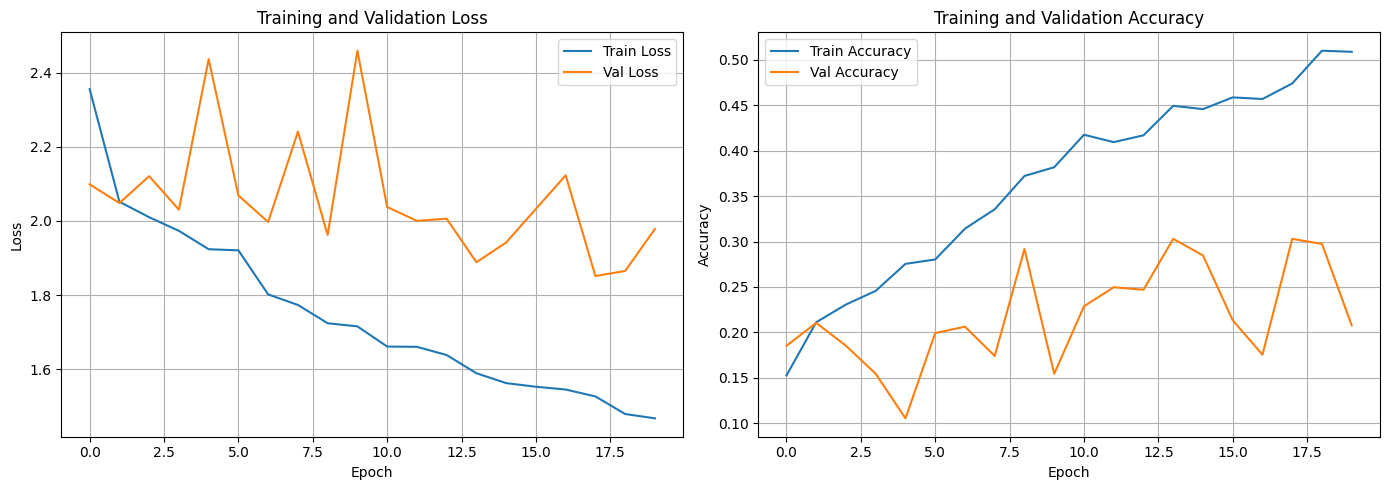


Loaded best model from epoch 14


Testing: 100%|██████████| 45/45 [00:01<00:00, 25.13it/s]



Test Accuracy: 28.75%



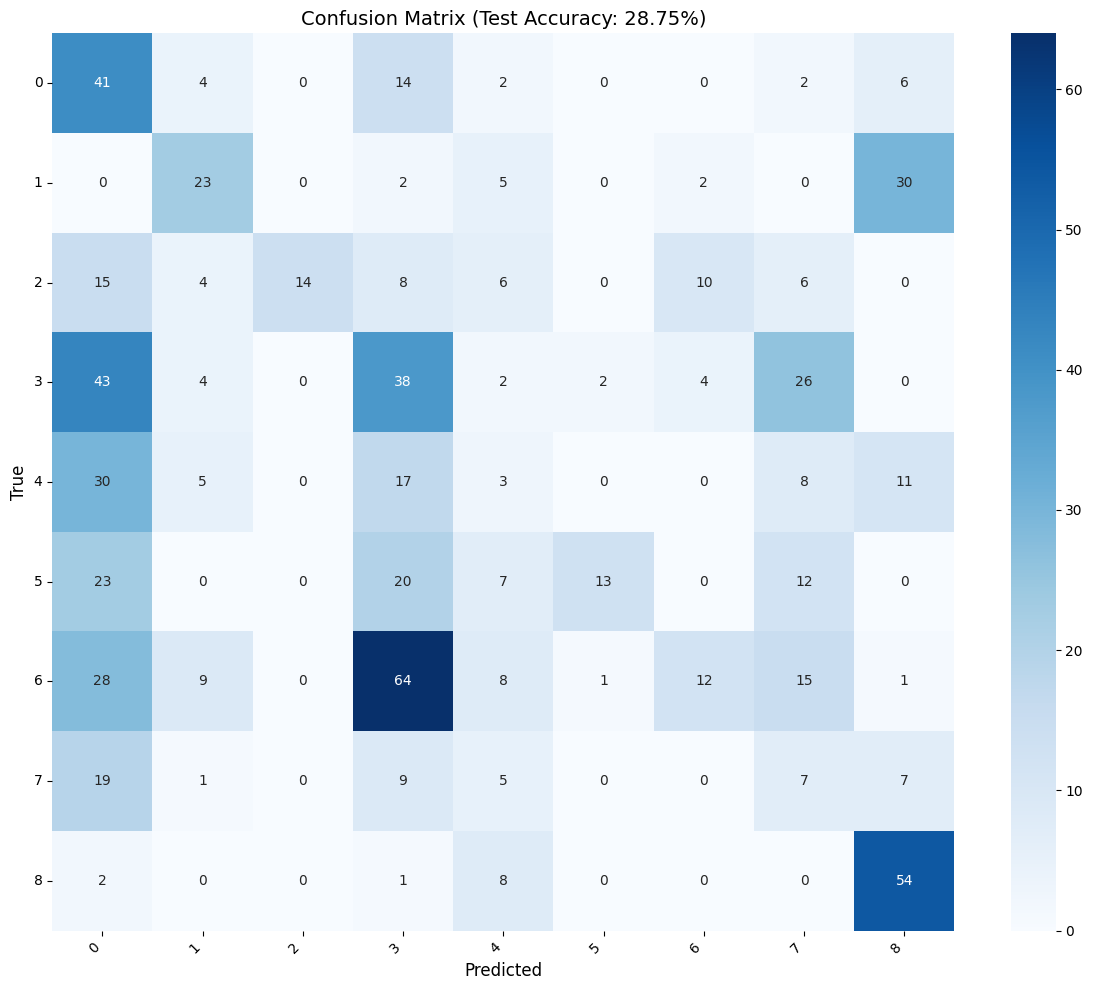


Classification Report:
              precision    recall  f1-score   support

           0     0.2040    0.5942    0.3037        69
           1     0.4600    0.3710    0.4107        62
           2     1.0000    0.2222    0.3636        63
           3     0.2197    0.3193    0.2603       119
           4     0.0652    0.0405    0.0500        74
           5     0.8125    0.1733    0.2857        75
           6     0.4286    0.0870    0.1446       138
           7     0.0921    0.1458    0.1129        48
           8     0.4954    0.8308    0.6207        65

    accuracy                         0.2875       713
   macro avg     0.4197    0.3094    0.2836       713
weighted avg     0.4113    0.2875    0.2681       713


Per-Class Accuracy:
0                   :  59.42% (69 samples)
1                   :  37.10% (62 samples)
2                   :  22.22% (63 samples)
3                   :  31.93% (119 samples)
4                   :   4.05% (74 samples)
5                   :  17.33% (75 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 0. Device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 1. Load data
# ---------------------------
image_array = np.load("images.npy", allow_pickle=True)
labels = np.load("labels.npy", allow_pickle=True)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")
print(f"Classes: {encoder.classes_}")
print(f"Class distribution: {np.bincount(y)}")

# Train/Val/Test split
train_idx, test_idx = train_test_split(
    np.arange(len(y)), test_size=0.15, random_state=42, stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=(0.15/0.85), random_state=42, stratify=y[train_idx]
)

print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}, Test size: {len(test_idx)}")

# ---------------------------
# 2. Dataset class
# ---------------------------
class WasteDataset(Dataset):
    def __init__(self, images, labels, indices, transform=None):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        img = self.images[i].astype(np.uint8)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label

# ---------------------------
# 3. Enhanced Transforms
# ---------------------------

# Compute mean and std from the training dataset
images = np.load("images.npy", allow_pickle=True).astype(np.float32) / 255.0  # scale 0-1
mean = images.mean(axis=(0,1,2))   # per channel mean
std = images.std(axis=(0,1,2))     # per channel std
print("Mean:", mean)
print("Std:", std)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = WasteDataset(image_array, y, train_idx, transform=train_transform)
val_dataset = WasteDataset(image_array, y, val_idx, transform=val_transform)
test_dataset = WasteDataset(image_array, y, test_idx, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0, pin_memory=True)

# ---------------------------
# 4. Custom CNN Model
# ---------------------------
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.adapt_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.fc1 = nn.Linear(512*4*4, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = self.adapt_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

print("Using Custom Improved CNN")
model = ImprovedCNN(num_classes, input_channels=3)
model = model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ---------------------------
# 5. Label Smoothing Loss
# ---------------------------
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, weight=None):
        super().__init__()
        self.epsilon = epsilon
        self.weight = weight
    
    def forward(self, output, target):
        n_class = output.size(1)
        log_preds = F.log_softmax(output, dim=1)
        loss = -log_preds.sum(dim=1).mean()
        nll = F.nll_loss(log_preds, target, weight=self.weight)
        return (1 - self.epsilon) * nll + self.epsilon * loss / n_class

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y[train_idx]),
    y=y[train_idx]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

criterion = LabelSmoothingCrossEntropy(epsilon=0.1, weight=class_weights)

# ---------------------------
# 6. Optimizer and Scheduler
# ---------------------------
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7
)

# ---------------------------
# 7. Training loop
# ---------------------------
num_epochs = 20
best_val_acc = 0
patience = 10
trigger_times = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), 
                desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for i, (X_batch, y_batch) in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    
    with torch.no_grad():
        for X_batch, y_batch in loop_val:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            loop_val.set_postfix(loss=val_loss/total, acc=correct/total)

    val_loss = val_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, "best_model.pth")
        print(f"✓ Best model saved with val_acc: {val_acc:.4f}")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

# ---------------------------
# 8. Plot training history
# ---------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 9. Test evaluation
# ---------------------------
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")

model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    loop_test = tqdm(test_loader, desc="Testing")
    for X_batch, y_batch in loop_test:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n{'='*50}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"{'='*50}\n")

# ---------------------------
# 10. Confusion matrix
# ---------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix (Test Accuracy: {test_acc*100:.2f}%)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 11. Classification report
# ---------------------------
print("\nClassification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=[str(c) for c in encoder.classes_], digits=4))

# ---------------------------
# 12. Per-class accuracy
# ---------------------------
print("\nPer-Class Accuracy:")
print("="*70)
for i, class_name in enumerate(encoder.classes_):
    class_mask = np.array(y_true) == i
    if class_mask.sum() > 0:
        class_acc = np.mean(np.array(y_pred)[class_mask] == i)
        print(f"{str(class_name):20s}: {class_acc*100:6.2f}% ({class_mask.sum()} samples)")

print("\n✓ Training complete!")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Final test accuracy: {test_acc*100:.2f}%")